# Imports and Settings

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity, BallTree
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
from matplotlib.ticker import ScalarFormatter
import os
from colorama import Fore, Style
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
import json
import plotly.express as px
from haversine import haversine, Unit
import math
import random
import seaborn as sns
from scipy.stats import circstd, circmean
from scipy.stats import gaussian_kde
import statsmodels.api as sm
import re


# File loading


In [67]:
columns = [
    "vehicleId", 
    "lat", 
    "lng", 
    # "dateStored", 
    "velocity",
    # "odometer", 
    # "engineVoltage", 
    "dateStoredHuman", 
    # "dateOnlyStoredHuman",    
    # "timeOnly",
    "bearing",
    "orientation", 
    "bearing_diff",
    "seconds_diff", 
    "acceleration",
    "isProblem",
    "trip_id",
    "velocity_diff",
    "distance_m"
]


input_dir   = "../../DataSets/API_Responses/Vehicle_Data/"
filename    = "all_vehicle_responses.csv"

## Enable matloblib UI backend

In [68]:
# %matplotlib tk

## Save plots file

In [69]:
PLOT_FOLDER_PATH = "./Plots/"

In [70]:
def merge_csv_file(input_dir, filename, columns):
    input_file = os.path.join(input_dir, filename)

    if not os.path.exists(input_file):
        raise FileNotFoundError(f"File '{filename}' not found in directory '{input_dir}'")

    try:
        # Read the CSV while allowing missing columns
        df = pd.read_csv(input_file, usecols=lambda x: x.strip() in columns, encoding='utf-8')
    except Exception as e:
        raise ValueError(f"Error reading '{input_file}': {e}")

    return df



merged_dfs = merge_csv_file(input_dir, filename, columns)
print(merged_dfs.head())


   vehicleId        lat        lng  velocity      dateStoredHuman  \
0          1  37.510833  22.385710       0.0  2024-06-06 17:02:17   
1          1  37.510603  22.385977       0.0  2024-06-06 17:02:20   
2          1  37.510640  22.385927       6.0  2024-06-06 17:02:25   
3          1  37.510750  22.385907       7.0  2024-06-06 17:02:31   
4          1  37.510877  22.385698      26.0  2024-06-06 17:02:37   

   seconds_diff  trip_id  distance_m     bearing orientation  bearing_diff  \
0           0.0        0        0.00  137.402376   Southeast          0.00   
1           3.0        0       34.75  312.778670   Northwest        175.38   
2           5.0        0        6.01  351.785725       North         39.01   
3           6.0        0       12.33  307.481149   Northwest         44.30   
4           6.0        0       23.17  318.388767   Northwest         10.91   

   velocity_diff  acceleration  isProblem  
0            0.0      0.000000          0  
1            0.0      0.0000

Set **Bounding Box** only for **Τρίπολη**

# Data Overview

Text(0.5, 1.0, 'Density of problem points on spatial coordinates')

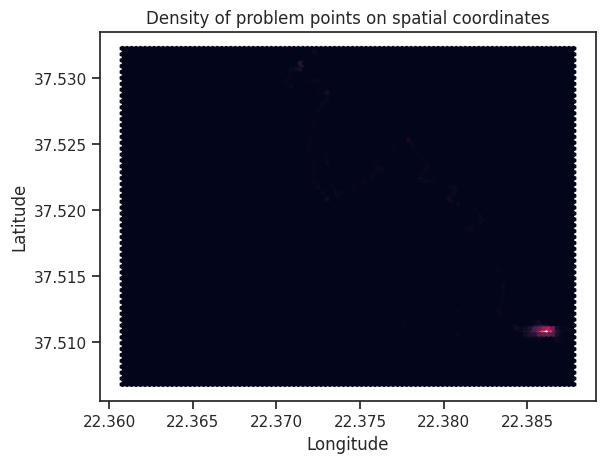

In [71]:
df = merged_dfs
df_danger = df[df['isProblem'] == 1]
df_danger = df[df['vehicleId'] == 15]


sns.set_theme(style="ticks")
fig, ax = plt.subplots()
#sns.jointplot(x=df_danger['lng'], y=df_danger['lat'], kind="hex", color="#4CB391", ax=ax)
ax.hexbin(x=df_danger['lng'], y=df_danger['lat'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.ticklabel_format(style='plain', axis='both')  # Disable scientific notation


ax.set_title('Density of problem points on spatial coordinates')

In [72]:
# df_danger[['lng', 'lat']].describe()

# Clustering

In [73]:
# #### MOCK DATA #####
#
# data = {
#     'lng': np.random.uniform(-180, 180, 200),
#     'lat': np.random.uniform(-90, 90, 200)
# }
# df = pd.DataFrame(data)
# df_danger = df

/tmp/ipykernel_9071/2364819354.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


Plot saved to ./Plots/


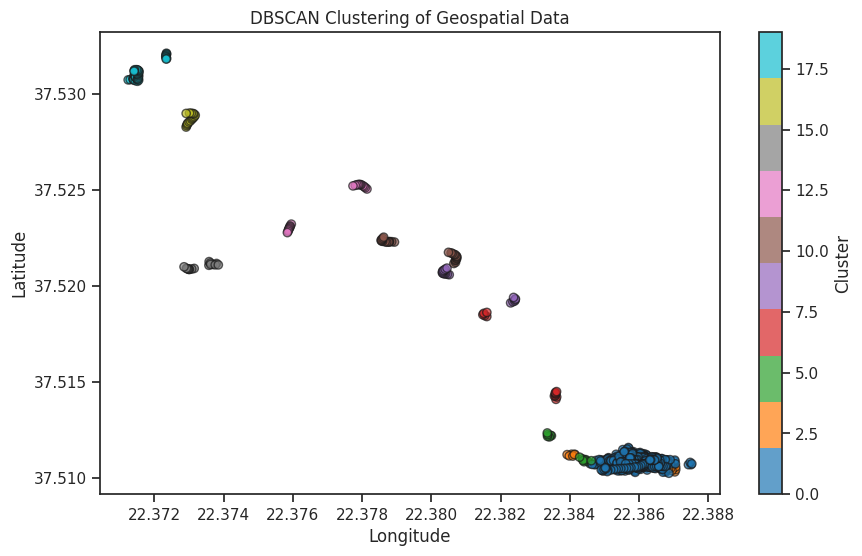

In [74]:
# Extracting the coordinates
coords = df_danger[['lng', 'lat']].values

# Standardizing the data for better clustering performance
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Applying DBSCAN
dbscan = DBSCAN(eps=0.02, min_samples=4)  # Adjust eps as needed
clusters = dbscan.fit_predict(coords_scaled)

df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


df_danger_cluster = df_danger[df_danger['cluster'] > -1]


# %matplotlib inline
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(df_danger_cluster['lng'], df_danger_cluster['lat'], c=df_danger_cluster['cluster'], cmap='tab10', edgecolors='k', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Geospatial Data')
plt.colorbar(label='Cluster')

# Save the plot
# Define the path to save the plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "DBSCAN_Clustering_of_Geospatial_Data.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


In [75]:
df_danger.columns

Index(['vehicleId', 'lat', 'lng', 'velocity', 'dateStoredHuman',
       'seconds_diff', 'trip_id', 'distance_m', 'bearing', 'orientation',
       'bearing_diff', 'velocity_diff', 'acceleration', 'isProblem',
       'cluster'],
      dtype='object')

In [76]:
df_danger.describe()

,vehicleId,lat,lng,velocity,seconds_diff,trip_id,distance_m,bearing,bearing_diff,velocity_diff,acceleration,isProblem,cluster
count,1517.0,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000,1517.000000
mean,15.0,37.514896,22.382625,19.600527,4.143705,139.842452,12.565485,205.088664,83.951365,0.000000,0.014870,0.127884,1.253131
std,0.0,0.006654,0.005373,12.671096,5.510165,69.293158,21.848633,108.365935,101.405398,8.033324,0.671664,0.334071,4.543167
min,15.0,37.506782,22.360795,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-39.000000,-4.444444,0.000000,-1.000000
25%,15.0,37.510752,22.380318,10.000000,1.000000,79.000000,4.510000,104.289875,5.770000,-4.000000,-0.277778,0.000000,-1.000000
50%,15.0,37.510957,22.385692,18.000000,2.000000,160.000000,9.220000,246.743638,27.530000,0.000000,0.000000,0.000000,0.000000
75%,15.0,37.520865,22.386168,28.000000,5.000000,207.000000,16.770000,291.443161,155.770000,3.000000,0.277778,0.000000,0.000000
max,15.0,37.532238,22.387758,55.000000,46.000000,208.000000,552.080000,359.286728,356.350000,39.000000,6.666667,1.000000,19.000000


## Showing convex hulls

/tmp/ipykernel_9071/2564165959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters


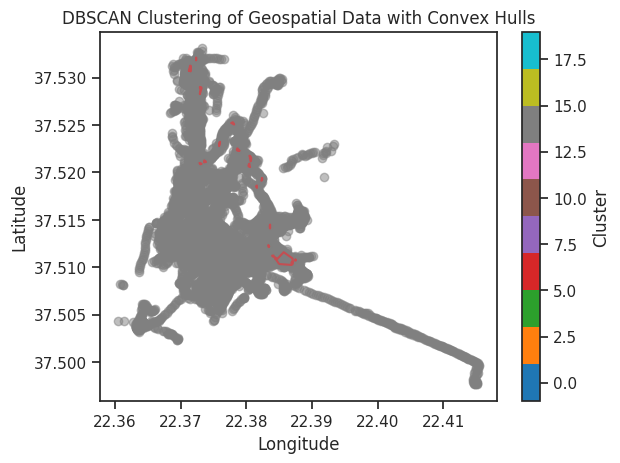

In [77]:
def plot_convex_hulls(df, clusters, normal_df_points):
    unique_clusters = set(clusters)
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters

    fig, ax = plt.subplots()  # Create figure and axis objects

    # Plot points first for colorbar
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', c=[colors(cluster)], s=10)

    ax.scatter(normal_df_points['lng'], normal_df_points['lat'], c='gray', alpha=0.5)

    # Plot Convex Hulls
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
            hull = ConvexHull(cluster_points)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the loop
            ax.plot(cluster_points[hull_points, 0], cluster_points[hull_points, 1], 'r-')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('DBSCAN Clustering of Geospatial Data with Convex Hulls')

    # Create colorbar using scatter points
    cb = fig.colorbar(plt.cm.ScalarMappable(cmap="tab10", norm=plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))),
                      ax=ax, label='Cluster')
    
    # Save the plot
    # Define the path to save the plot
    plot_save_path = os.path.join(PLOT_FOLDER_PATH, "DBSCAN_Clustering_of_Geospatial_Data_with_Convex_Hulls")
    plt.savefig(plot_save_path, bbox_inches='tight')
    plt.show()

plot_convex_hulls(df_danger_cluster, clusters, df[df['isProblem'] == 0])


Get specific **Cluster's BBOX**

In [78]:
def get_bbox_of_clusters(df, clusters):
    cluster_bboxes = {}

    # Iterate over unique clusters (excluding -1 for noise)
    unique_clusters = sorted(set(clusters) - {-1})  # Exclude noise points (-1)

    for cluster in unique_clusters:
        # Filter the points of the current cluster
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']]
        
        # Get the minimum and maximum lng and lat for the bounding box
        min_lng = cluster_points['lng'].min()
        max_lng = cluster_points['lng'].max()
        min_lat = cluster_points['lat'].min()
        max_lat = cluster_points['lat'].max()

        # Store the bounding box for the current cluster
        cluster_bboxes[cluster] = {
            'min_lng': min_lng,
            'max_lng': max_lng,
            'min_lat': min_lat,
            'max_lat': max_lat
        }

    return cluster_bboxes

cluster_bboxes = get_bbox_of_clusters(df_danger_cluster, clusters)

# Display the bounding boxes for each cluster
for cluster, bbox in cluster_bboxes.items():
    print(f"Cluster {cluster}: {bbox}")


Cluster 0: {'min_lng': 22.384585, 'max_lng': 22.3870483, 'min_lat': 37.5102516, 'max_lat': 37.51159}
Cluster 1: {'min_lng': 22.3874233, 'max_lng': 22.3875216, 'min_lat': 37.5106983, 'max_lat': 37.5108166}
Cluster 2: {'min_lng': 22.3868549, 'max_lng': 22.3870566, 'min_lat': 37.5103233, 'max_lat': 37.5105766}
Cluster 3: {'min_lng': 22.3839199, 'max_lng': 22.3841449, 'min_lat': 37.5111466, 'max_lat': 37.5112433}
Cluster 4: {'min_lng': 22.3842799, 'max_lng': 22.3846183, 'min_lat': 37.5108516, 'max_lat': 37.5110883}
Cluster 5: {'min_lng': 22.3833466, 'max_lng': 22.3834666, 'min_lat': 37.5121433, 'max_lat': 37.51235}
Cluster 6: {'min_lng': 22.3835516, 'max_lng': 22.3836183, 'min_lat': 37.5140999, 'max_lat': 37.5145033}
Cluster 7: {'min_lng': 22.3814849, 'max_lng': 22.3816016, 'min_lat': 37.5184116, 'max_lat': 37.5186266}
Cluster 8: {'min_lng': 22.3822883, 'max_lng': 22.3824266, 'min_lat': 37.5191233, 'max_lat': 37.5194066}
Cluster 9: {'min_lng': 22.3803183, 'max_lng': 22.380515, 'min_lat': 3

### Prepare the DF

In [79]:
# *Get specific columns 
_ = merged_dfs.copy()
bearings_df = _[['vehicleId', 'lat', 'lng', 'dateStoredHuman' ,'bearing', 'orientation', 'seconds_diff', 'trip_id']]
print(bearings_df)

# Filter for vehicleId == 1
df_vehicle1 = df[df['vehicleId'] == 1]

# Count occurrences of each trip_id
trip_counts = df_vehicle1['trip_id'].value_counts()

# Get the trip_id with the highest count
most_frequent_trip_id = trip_counts.idxmax()

# Display the result
print(f"The trip_id with the most rows for vehicleId 1 is: {most_frequent_trip_id}")


       vehicleId        lat        lng      dateStoredHuman     bearing  \
0              1  37.510833  22.385710  2024-06-06 17:02:17  137.402376   
1              1  37.510603  22.385977  2024-06-06 17:02:20  312.778670   
2              1  37.510640  22.385927  2024-06-06 17:02:25  351.785725   
3              1  37.510750  22.385907  2024-06-06 17:02:31  307.481149   
4              1  37.510877  22.385698  2024-06-06 17:02:37  318.388767   
...          ...        ...        ...                  ...         ...   
28929         20  37.531460  22.369768  2025-03-06 13:09:13  231.663210   
28930         20  37.531275  22.369473  2025-03-06 13:09:15  235.207818   
28931         20  37.531122  22.369195  2025-03-06 13:09:19  278.389323   
28932         20  37.531148  22.368967  2025-03-06 13:09:21  294.596339   
28933         20  37.531243  22.368705  2025-03-06 13:09:24         NaN   

      orientation  seconds_diff  trip_id  
0       Southeast           0.0        0  
1       North

### Get trip_id's rows

In [80]:
print(df[(df['vehicleId'] == 1) & (df['trip_id'] == most_frequent_trip_id)].head(5))

     vehicleId        lat        lng  velocity      dateStoredHuman  \
946          1  37.510722  22.387033      16.0  2024-06-08 17:32:23   
947          1  37.510692  22.387185       8.0  2024-06-08 17:32:30   
948          1  37.510670  22.387042       9.0  2024-06-08 17:32:38   
949          1  37.510645  22.386773      22.0  2024-06-08 17:32:41   
950          1  37.510685  22.386552      34.0  2024-06-08 17:32:43   

     seconds_diff  trip_id  distance_m     bearing orientation  bearing_diff  \
946           0.0       64        0.00  103.998723        East          0.00   
947           7.0       64       13.82  259.248208        West        155.25   
948           8.0       64       12.90  263.300439        West          4.05   
949           3.0       64       23.88  282.783117        West         19.48   
950           2.0       64       20.10  277.535628        West          5.25   

     velocity_diff  acceleration  isProblem  
946          -40.0      0.000000          0  


## Plot real **directional spread**

### 1️⃣ Violin Plot (Distribution)

Plot saved to ./Plots/


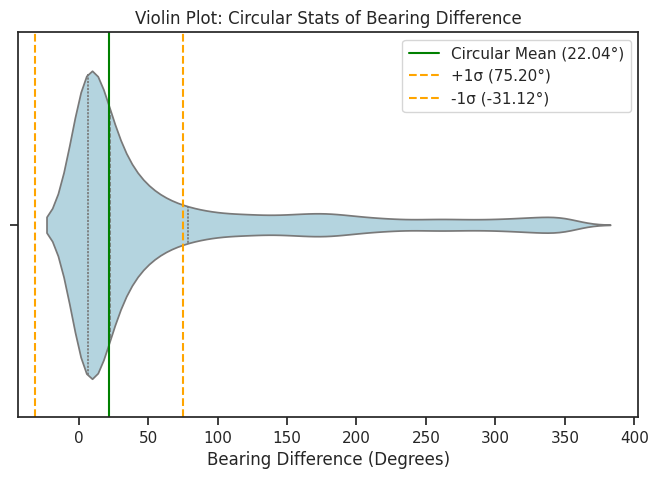

In [81]:
# Convert to radians for circular statistics
bearing_diff_rad = np.deg2rad(merged_dfs['bearing_diff'])

# Compute circular mean and circular standard deviation
circular_mean_rad = circmean(bearing_diff_rad, high=np.pi, low=-np.pi)
circular_std_rad = circstd(bearing_diff_rad, high=np.pi, low=-np.pi)

# Convert back to degrees for plotting
circular_mean_deg = np.rad2deg(circular_mean_rad)
circular_std_deg = np.rad2deg(circular_std_rad)

plt.figure(figsize=(8, 5))

# Create the violin plot
sns.violinplot(x=merged_dfs['bearing_diff'], inner="quartile", color="lightblue")

# Mark the circular mean and circular standard deviation
plt.axvline(x=circular_mean_deg, color='green', linestyle='-', label=f'Circular Mean ({circular_mean_deg:.2f}°)')
plt.axvline(x=circular_mean_deg + circular_std_deg, color='orange', linestyle='--', label=f'+1σ ({(circular_mean_deg + circular_std_deg):.2f}°)')
plt.axvline(x=circular_mean_deg - circular_std_deg, color='orange', linestyle='--', label=f'-1σ ({(circular_mean_deg - circular_std_deg):.2f}°)')

# Labels and title
plt.xlabel('Bearing Difference (Degrees)')
plt.title('Violin Plot: Circular Stats of Bearing Difference')

# Show legend
plt.legend()

# Save and display
plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


In [82]:
print((merged_dfs['bearing_diff'] < 0).sum())


0


### 1️⃣ Polar Plot: Bearing Difference Distribution

Polar plot saved to ./Plots/Polar Plot


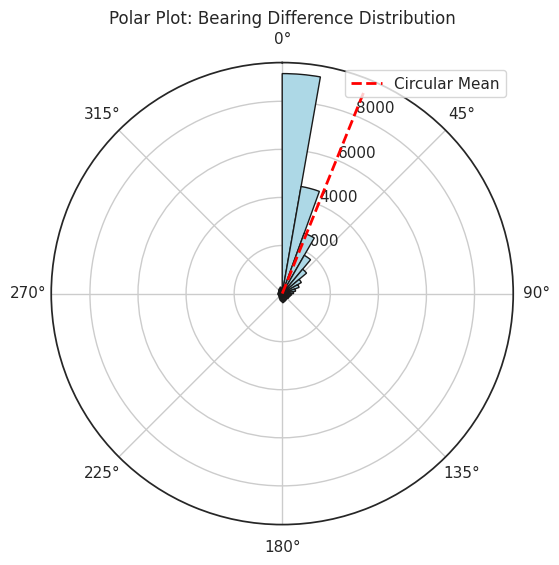

In [83]:
# Convert to radians and wrap angles to [0, 2π]
bearing_diff_rad = np.deg2rad(merged_dfs['bearing_diff'] % 360)

# Define number of bins (adjust based on resolution you want)
num_bins = 36  # 10-degree bins

# Create histogram
counts, bin_edges = np.histogram(bearing_diff_rad, bins=num_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

# Plot histogram as bars
bars = ax.bar(bin_centers, counts, width=(2 * np.pi / num_bins), bottom=0.0, color='lightblue', edgecolor='k')

# Optional: highlight circular mean
from scipy.stats import circmean
circular_mean_rad = circmean(bearing_diff_rad, high=2*np.pi, low=0)
ax.plot([circular_mean_rad, circular_mean_rad], [0, max(counts)], color='red', linestyle='--', linewidth=2, label='Circular Mean')

# Format and show
ax.set_theta_zero_location('N')  # 0° at the top
ax.set_theta_direction(-1)       # Clockwise
plt.title("Polar Plot: Bearing Difference Distribution")
plt.legend(loc='upper right')

# Save and display
# Define the path to save the plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Polar Plot")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Polar plot saved to {plot_save_path}")
plt.show()


###  2️⃣ Boxplot (Detect Outliers)

Boxplot saved to ./Plots/


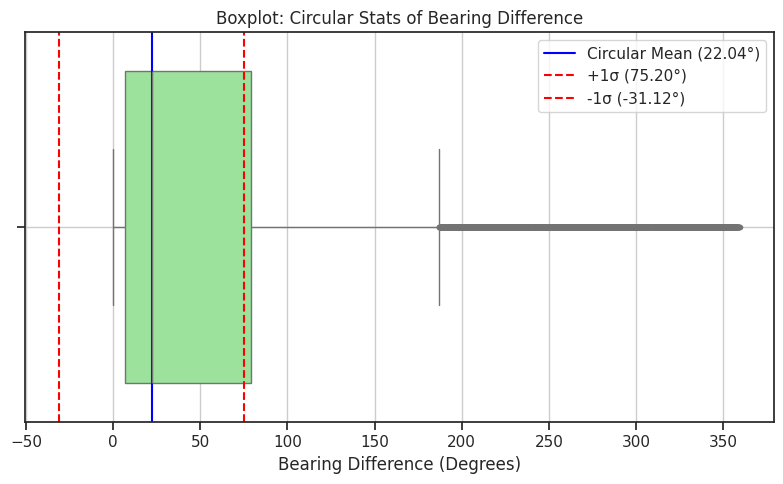

In [84]:
# Convert to radians for circular statistics
bearing_diff_rad = np.deg2rad(merged_dfs['bearing_diff'])

# Compute circular mean and circular standard deviation
circular_mean_rad = circmean(bearing_diff_rad, high=np.pi, low=-np.pi)
circular_std_rad = circstd(bearing_diff_rad, high=np.pi, low=-np.pi)

# Convert back to degrees for plotting
circular_mean_deg = np.rad2deg(circular_mean_rad)
circular_std_deg = np.rad2deg(circular_std_rad)

# Create the boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_dfs['bearing_diff'], color='lightgreen', fliersize=3)

# Overlay circular mean and ±1σ
plt.axvline(x=circular_mean_deg, color='blue', linestyle='-', label=f'Circular Mean ({circular_mean_deg:.2f}°)')
plt.axvline(x=circular_mean_deg + circular_std_deg, color='red', linestyle='--', label=f'+1σ ({(circular_mean_deg + circular_std_deg):.2f}°)')
plt.axvline(x=circular_mean_deg - circular_std_deg, color='red', linestyle='--', label=f'-1σ ({(circular_mean_deg - circular_std_deg):.2f}°)')

# Labels and title
plt.xlabel('Bearing Difference (Degrees)')
plt.title('Boxplot: Circular Stats of Bearing Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and display
plot_save_path = PLOT_FOLDER_PATH.replace(".png", "_boxplot.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Boxplot saved to {plot_save_path}")
plt.show()


###  3️⃣ Color by Density

Plot saved to ./Plots/Scatter_bearings_vs_seconds_diff_density.png


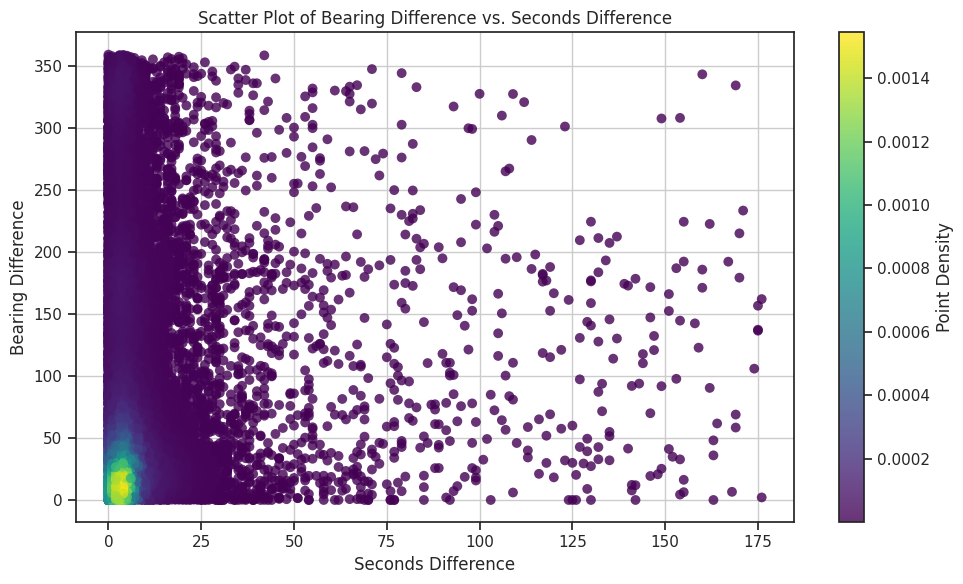

In [85]:
x = merged_dfs['seconds_diff']
y = merged_dfs['bearing_diff']

# Calculate point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=z, cmap='viridis', s=50, edgecolors='none', alpha=0.8)
plt.colorbar(scatter, label='Point Density')
plt.title('Scatter Plot of Bearing Difference vs. Seconds Difference')
plt.xlabel('Seconds Difference')
plt.ylabel('Bearing Difference')
plt.grid(True)
plt.tight_layout()

# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Scatter_bearings_vs_seconds_diff_density.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Plot saved to {plot_save_path}")
plt.show()


###  4️⃣ Scatter + Trend Line + Thresholds

Static plot saved to ./Plots/Enhanced_Scatter_with_LOESS.png


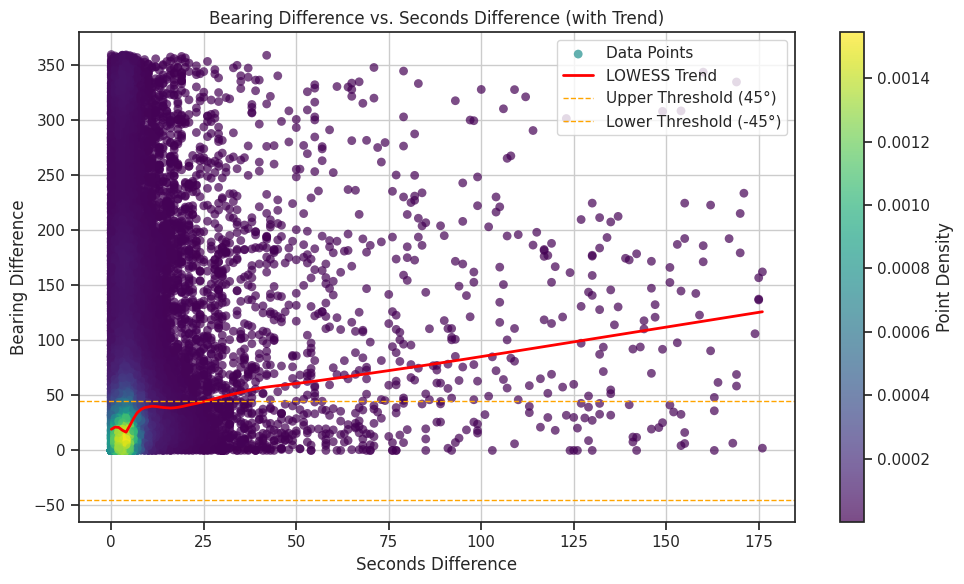

In [86]:
x = merged_dfs['seconds_diff']
y = merged_dfs['bearing_diff']

# Calculate density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# LOWESS smoothing
lowess = sm.nonparametric.lowess
smoothed = lowess(y, x, frac=0.2)  # Adjust frac for smoothness

plt.figure(figsize=(10, 6))

# Scatter colored by density
scatter = plt.scatter(x, y, c=z, cmap='viridis', s=40, edgecolors='none', alpha=0.7, label='Data Points')

# LOWESS line
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS Trend')

# Optional thresholds (customize as needed)
plt.axhline(y=45, color='orange', linestyle='--', linewidth=1, label='Upper Threshold (45°)')
plt.axhline(y=-45, color='orange', linestyle='--', linewidth=1, label='Lower Threshold (-45°)')

plt.title('Bearing Difference vs. Seconds Difference (with Trend)')
plt.xlabel('Seconds Difference')
plt.ylabel('Bearing Difference')
plt.colorbar(scatter, label='Point Density')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Enhanced_Scatter_with_LOESS.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Static plot saved to {plot_save_path}")
plt.show()


### 5️⃣ KDE Plot for Angular Data

Static plot saved to ./Plots/KDE_of_Bearing_Differences_(Wrapped).png


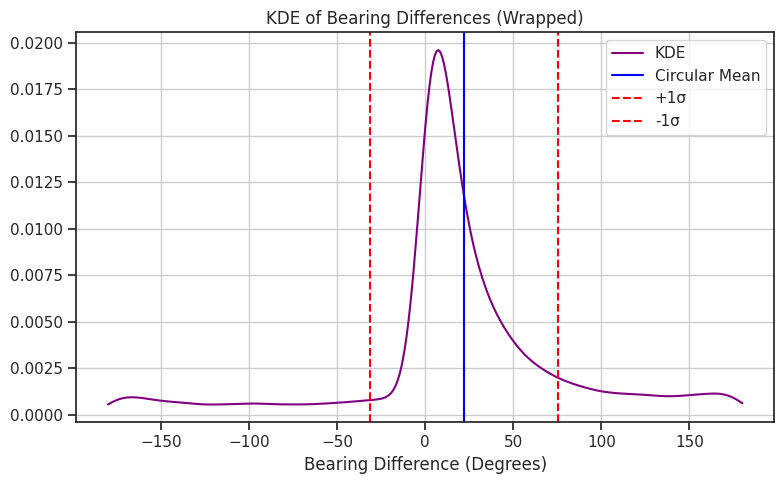

In [87]:
# Wrap angles between -180 and 180
angles_deg = merged_dfs['bearing_diff']
angles_deg_wrapped = ((angles_deg + 180) % 360) - 180

# KDE estimation
kde = gaussian_kde(angles_deg_wrapped)
x_vals = np.linspace(-180, 180, 360)
kde_vals = kde(x_vals)

plt.figure(figsize=(8, 5))
plt.plot(x_vals, kde_vals, color='purple', label='KDE')
plt.axvline(x=circular_mean_deg, color='blue', linestyle='-', label='Circular Mean')
plt.axvline(x=circular_mean_deg + circular_std_deg, color='red', linestyle='--', label='+1σ')
plt.axvline(x=circular_mean_deg - circular_std_deg, color='red', linestyle='--', label='-1σ')
plt.title("KDE of Bearing Differences (Wrapped)")
plt.xlabel("Bearing Difference (Degrees)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "KDE_of_Bearing_Differences_(Wrapped).png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Static plot saved to {plot_save_path}")
plt.show()


### 6️⃣ Circular Heatmap

Static plot saved to ./Plots/Circular_Heatmap.png


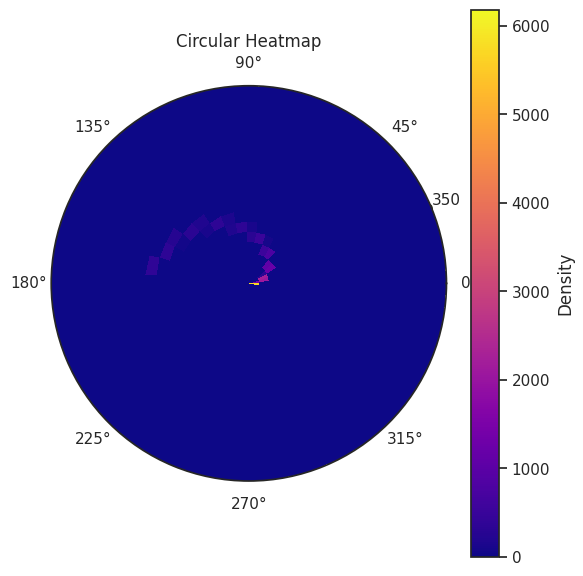

In [88]:
# Create 2D histogram: angle + magnitude or time
angle_bins = np.linspace(-np.pi, np.pi, 36)
magnitude_bins = np.linspace(0, merged_dfs['bearing_diff'].max(), 20)

H, _, _ = np.histogram2d(bearing_diff_rad, merged_dfs['bearing_diff'], bins=[angle_bins, magnitude_bins])

theta, r = np.meshgrid(angle_bins[:-1], magnitude_bins[:-1])
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
heatmap = ax.pcolormesh(theta, r, H.T, cmap='plasma')
plt.colorbar(heatmap, label='Density')
ax.set_title("Circular Heatmap")
plt.tight_layout()
# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Circular_Heatmap.png")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Static plot saved to {plot_save_path}")
plt.show()



### 7️⃣ Combine Plots in a Grid

Static plot saved to ./Plots/Various_Views_of_Bearing_Differences


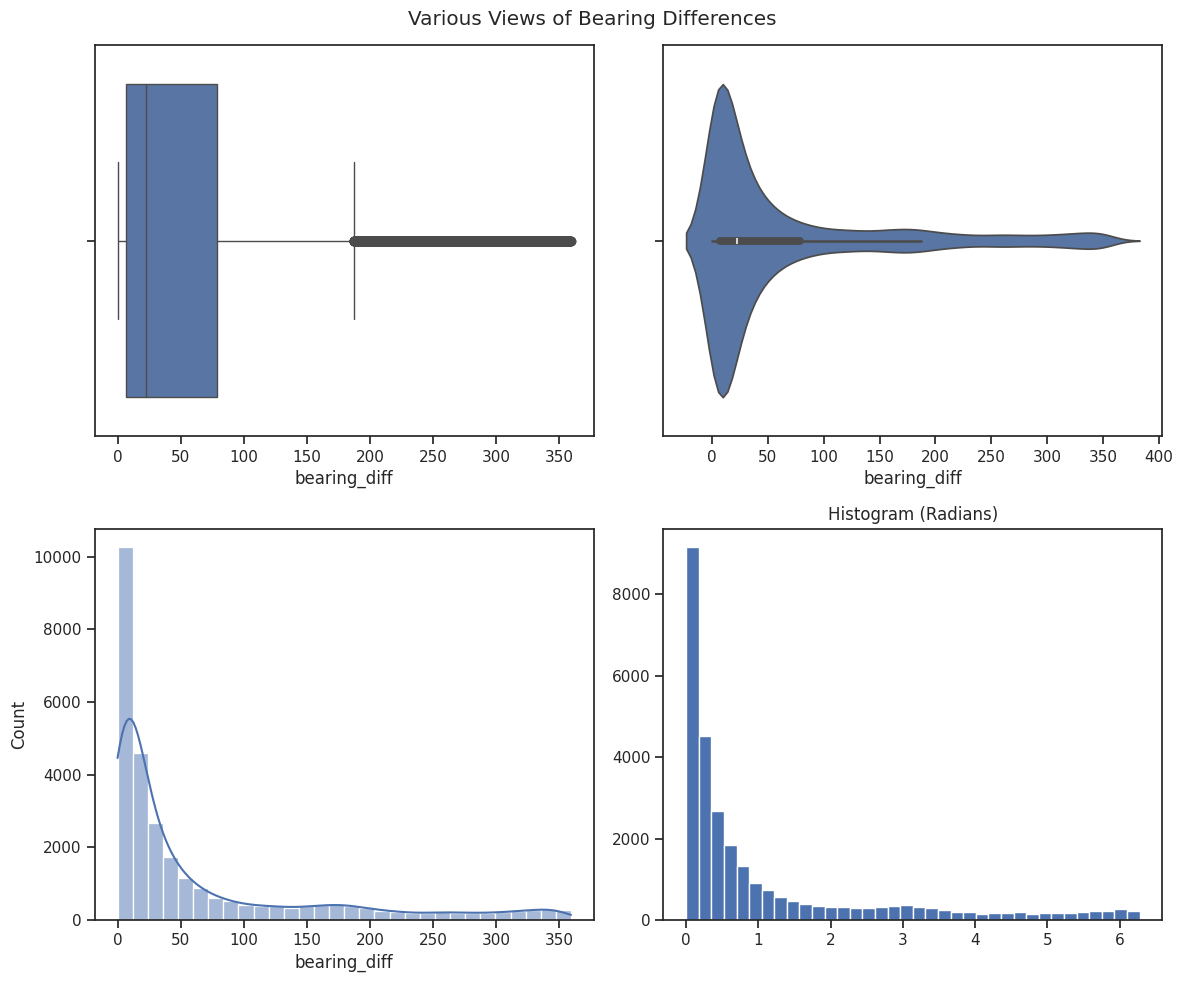

In [89]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(x=merged_dfs['bearing_diff'], ax=axs[0, 0])
sns.violinplot(x=merged_dfs['bearing_diff'], ax=axs[0, 1])
sns.histplot(merged_dfs['bearing_diff'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 1].hist(bearing_diff_rad, bins=36)
axs[1, 1].set_title('Histogram (Radians)')

fig.suptitle("Various Views of Bearing Differences")
plt.tight_layout()
# Save
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Various_Views_of_Bearing_Differences")
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Static plot saved to {plot_save_path}")
plt.show()


## Plot bearings vs 10 seconds_diff

/tmp/ipykernel_9071/2563032348.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', 20)  # Using the 'tab20' colormap


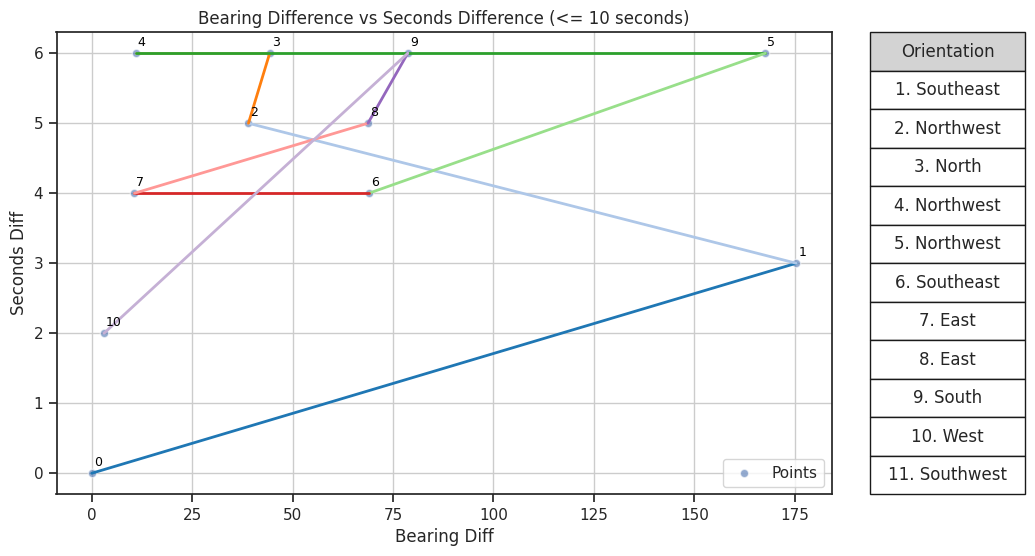

In [90]:
# Filter the DataFrame and take only the first 20 rows
filtered_df = merged_dfs[
    (merged_dfs['seconds_diff'] <= 10) & 
    (merged_dfs['vehicleId'] == 1) & 
    (merged_dfs['trip_id'] == 0)
]


# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot (swapped axes)
ax.scatter(
    filtered_df['bearing_diff'],
    filtered_df['seconds_diff'],
    alpha=0.6,
    edgecolors='w',
    label='Points'
)

# Generate a list of 20 distinct colors using a colormap
colors = plt.cm.get_cmap('tab20', 20)  # Using the 'tab20' colormap

# Plot segments with changing color for each segment
for i in range(len(filtered_df) - 1):
    # Get the x and y values for the two points
    x_start = filtered_df['bearing_diff'].iloc[i]
    y_start = filtered_df['seconds_diff'].iloc[i]
    x_end = filtered_df['bearing_diff'].iloc[i + 1]
    y_end = filtered_df['seconds_diff'].iloc[i + 1]

    # Assign a unique color for each segment from the 'tab20' colormap
    color = colors(i)  # Get a different color for each segment

    # Plot each segment with its own color
    ax.plot([x_start, x_end], [y_start, y_end], color=color, lw=2)

# Add incremental labels
for i, (x, y) in enumerate(zip(filtered_df['bearing_diff'], filtered_df['seconds_diff'])):
    ax.text(x + 0.5, y + 0.1, str(i), fontsize=9, color='black')

# Prepare the orientation labels
orientation_list = [f"{i+1}. {orientation}" for i, orientation in enumerate(filtered_df['orientation'])]

# Prepare cell text for the table
cell_text = [[orientation] for orientation in orientation_list]

# Add the table on the right side of the plot (without color)
table = ax.table(cellText=cell_text,
                 colLabels=['Orientation'],
                 loc='right',
                 cellLoc='center',
                 colColours=['lightgray'],  # Keep the header background color if desired
                 bbox=[1.05, 0, 0.2, 1])  # Adjust bbox for position and size

# Labels and title
ax.set_title('Bearing Difference vs Seconds Difference (<= 10 seconds)')
ax.set_xlabel('Bearing Diff')
ax.set_ylabel('Seconds Diff')
ax.grid(True)
ax.legend()





plot_save_path = os.path.join(PLOT_FOLDER_PATH, "bearings_vs_seconds_diff.png")
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()


# Trajectory Analysis

#### Filter trips for calculations

In [91]:
# !Ensure trip_id has at least 6 rows, otherwise, do not calculate any slaloms
trip_counts = merged_dfs.groupby(['vehicleId', 'trip_id']).size().reset_index(name='count')
print(trip_counts)

trip_distances = merged_dfs.groupby(['vehicleId', 'trip_id'])['distance_m'].sum().reset_index(name='total_distance_m')
print(trip_distances)

# *Filter only those trip_ids with more than 10 rows distance traveled > 50
valid_trips = trip_counts[(trip_counts['count'] > 10) & (trip_distances['total_distance_m'] > 50.00)]

filtered_merged_dfs = merged_dfs.copy()
filtered_merged_dfs = pd.merge(merged_dfs, valid_trips[['vehicleId', 'trip_id']], on=['vehicleId', 'trip_id'], how='inner')
print(f"Row difference excluded: {len(merged_dfs)} - {len(filtered_merged_dfs)} = {len(merged_dfs) - len(filtered_merged_dfs)}")



      vehicleId  trip_id  count
0             1        0     13
1             1        1      2
2             1        2      6
3             1        3      4
4             1        4      1
...         ...      ...    ...
1452         20        7      3
1453         20        8     89
1454         20        9     11
1455         20       10      7
1456         20       11     10

[1457 rows x 3 columns]
      vehicleId  trip_id  total_distance_m
0             1        0            291.50
1             1        1              3.88
2             1        2             99.97
3             1        3             44.61
4             1        4              0.00
...         ...      ...               ...
1452         20        7             21.63
1453         20        8           1597.54
1454         20        9            253.65
1455         20       10             40.92
1456         20       11            239.76

[1457 rows x 3 columns]
Row difference excluded: 28934 - 25456 = 3478


### Delete previous random vehicle trips

In [92]:
# Regular expression pattern that matches your generated filenames
pattern = re.compile(r'^Coordinates_for_Vehicle_.*_-_Trip_.*_-_\d+_Data_Points\.png$')

# List all files in the plot directory
for filename in os.listdir(PLOT_FOLDER_PATH):
    if pattern.match(filename):
        file_path = os.path.join(PLOT_FOLDER_PATH, filename)
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")


### Plot random vehicle ids and trip_ids

Iteration 1 - vehicleId: 9, trip_number: 81
Plot saved to ./Plots/bearings_vs_seconds_diff.png


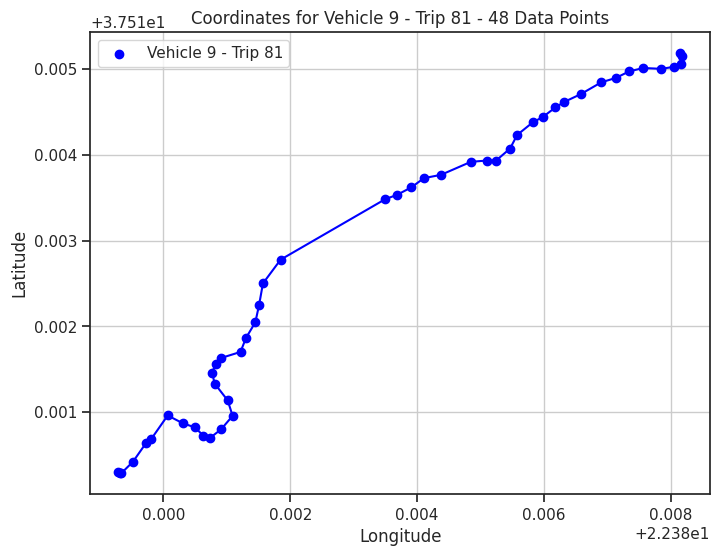

Iteration 2 - vehicleId: 7, trip_number: 116
Plot saved to ./Plots/bearings_vs_seconds_diff.png


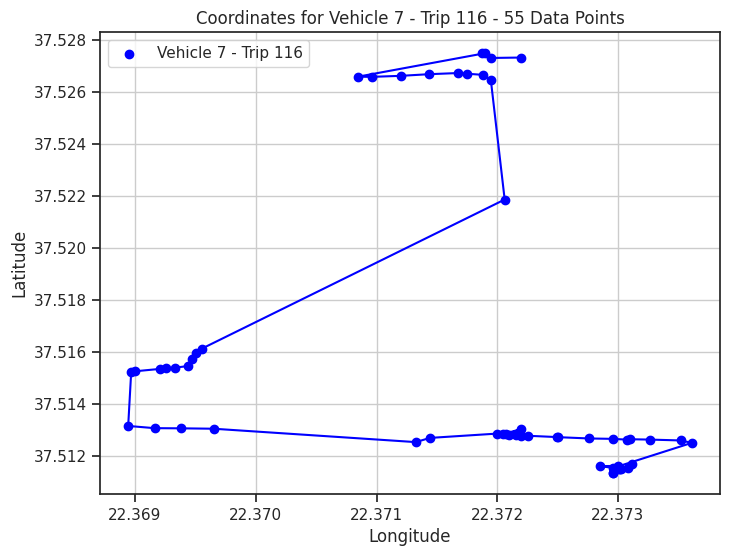

Iteration 3 - vehicleId: 7, trip_number: 169
Plot saved to ./Plots/bearings_vs_seconds_diff.png


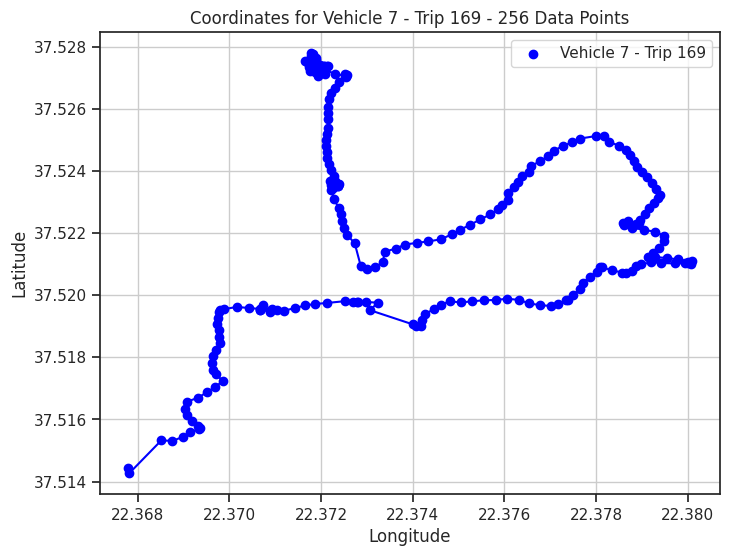

Iteration 4 - vehicleId: 9, trip_number: 2
Plot saved to ./Plots/bearings_vs_seconds_diff.png


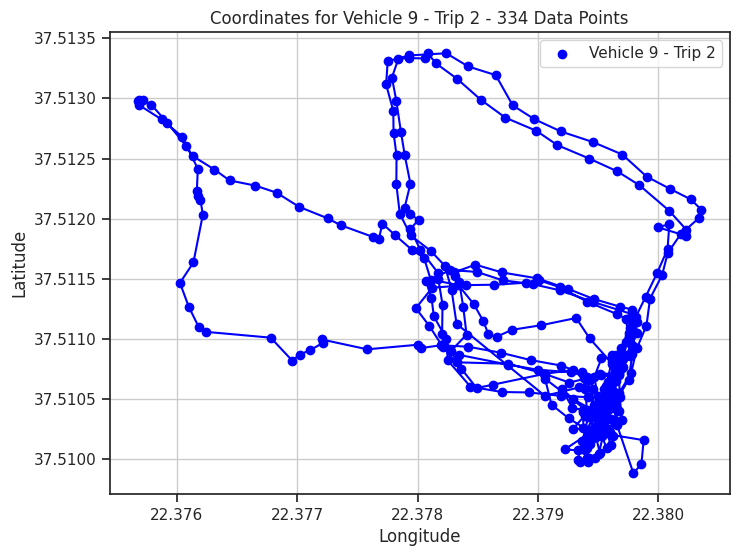

Iteration 5 - vehicleId: 9, trip_number: 75
Plot saved to ./Plots/bearings_vs_seconds_diff.png


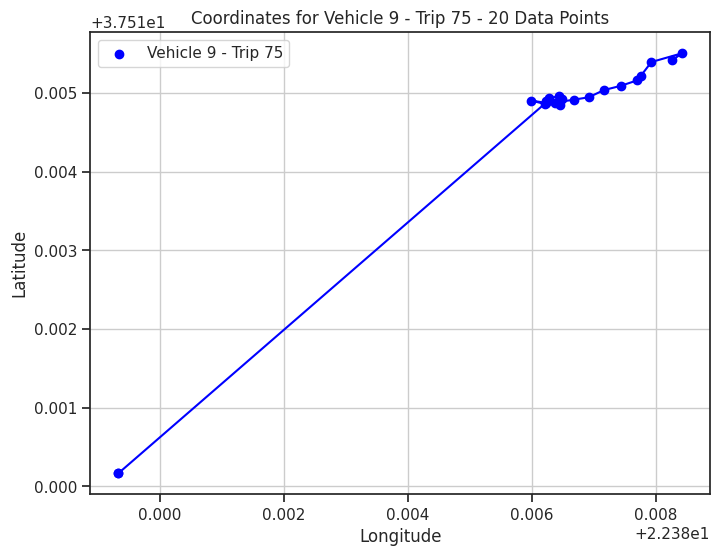

Iteration 6 - vehicleId: 9, trip_number: 81
Plot saved to ./Plots/bearings_vs_seconds_diff.png


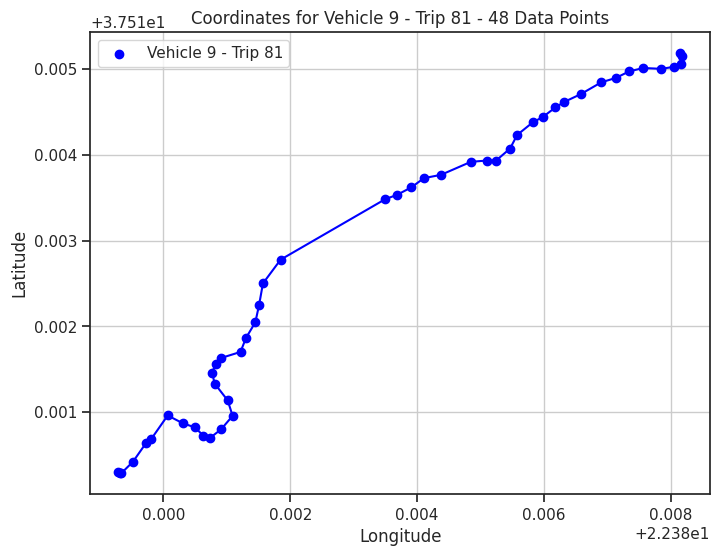

Iteration 7 - vehicleId: 5, trip_number: 1
Plot saved to ./Plots/bearings_vs_seconds_diff.png


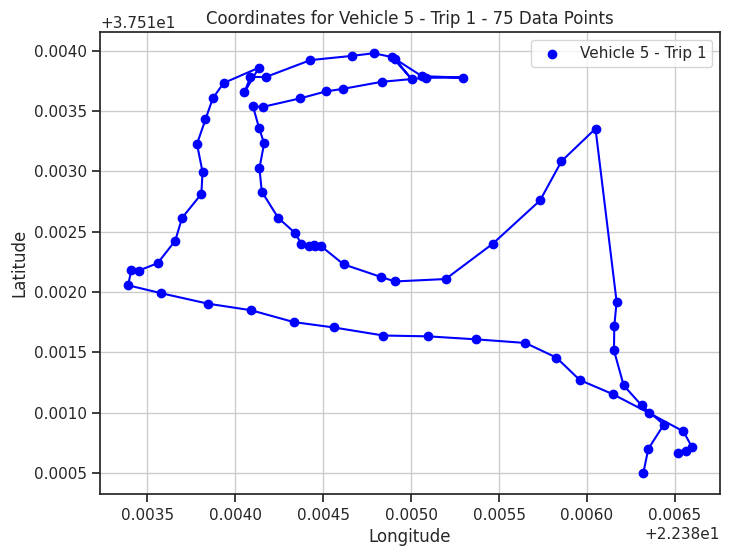

Iteration 8 - vehicleId: 1, trip_number: 164
Plot saved to ./Plots/bearings_vs_seconds_diff.png


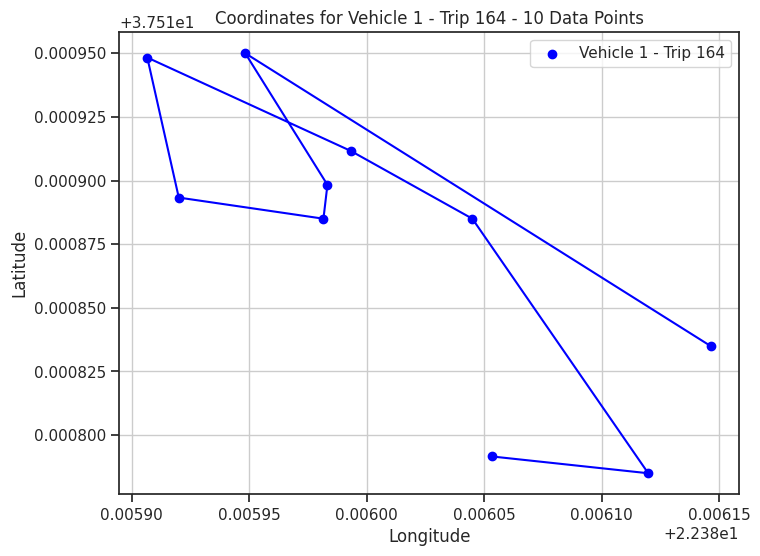

Iteration 9 - vehicleId: 9, trip_number: 498
Plot saved to ./Plots/bearings_vs_seconds_diff.png


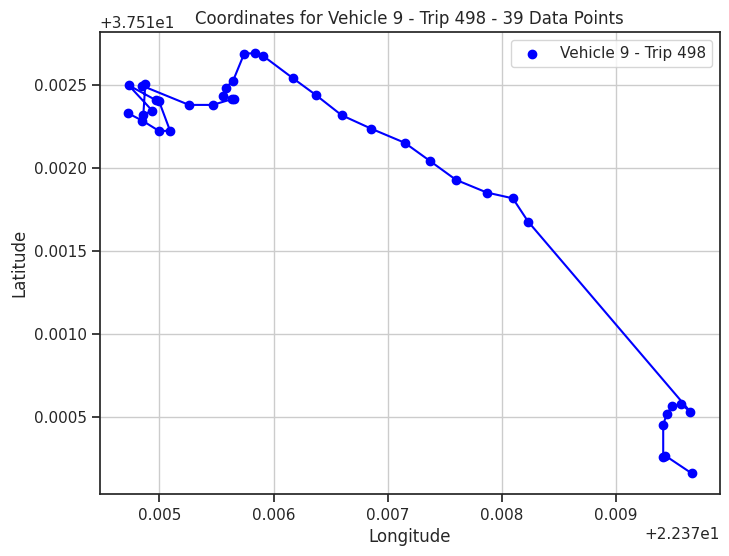

Iteration 10 - vehicleId: 1, trip_number: 169
Plot saved to ./Plots/bearings_vs_seconds_diff.png


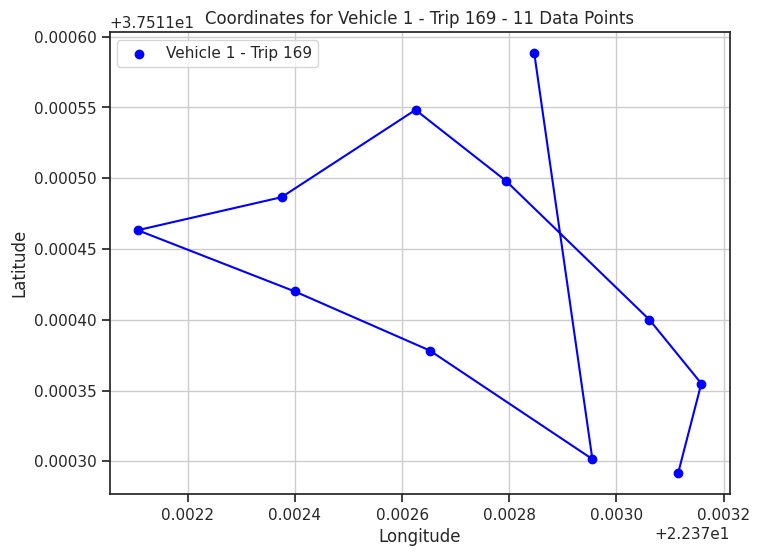

Vehicle and Trip ID pairs:  {1: {'vehicleId': 9, 'trip_number': 81}, 2: {'vehicleId': 7, 'trip_number': 116}, 3: {'vehicleId': 7, 'trip_number': 169}, 4: {'vehicleId': 9, 'trip_number': 2}, 5: {'vehicleId': 9, 'trip_number': 75}, 6: {'vehicleId': 9, 'trip_number': 81}, 7: {'vehicleId': 5, 'trip_number': 1}, 8: {'vehicleId': 1, 'trip_number': 164}, 9: {'vehicleId': 9, 'trip_number': 498}, 10: {'vehicleId': 1, 'trip_number': 169}}


In [93]:
# Define the random_ID function
def random_ID(df):
    """
    This function randomly selects a vehicleId-trip_id pair from the DataFrame where the trip count >= 10.
    
    Args:
        df (pd.DataFrame): DataFrame containing trip data with 'vehicleId' and 'trip_id' columns.

    Returns:
        tuple: A tuple containing the selected vehicleId and trip number.
    """
    # Group by vehicleId and trip_id, and count occurrences
    trip_counts = df.groupby(['vehicleId', 'trip_id']).size().reset_index(name='count')
    # Filter to keep only trip counts >= 10
    valid_trip_counts = trip_counts[trip_counts['count'] >= 10]
    
    if valid_trip_counts.empty:
        return None, None  # If no valid trip found
    
    # Randomly sample one row
    selected_trip = valid_trip_counts.sample(1).iloc[0]
    return selected_trip['vehicleId'], selected_trip['trip_id']

# Create an empty dictionary to store vehicleId and trip number pairs
vehicle_trip_dict = {}


# Loop through 10 times to generate and store random vehicleId-trip_id pairs
for i in range(10):
    vehicle_id, trip_id = random_ID(merged_dfs)
    
    if vehicle_id is None or trip_id is None:
        print(f"Iteration {i+1} - No valid vehicleId-trip_id found.")
        continue
    
    # Store the pair in the dictionary, also storing the trip number as trip_id
    vehicle_trip_dict[i+1] = {'vehicleId': vehicle_id, 'trip_number': trip_id}
    
    # Print the selected vehicleId and trip number
    print(f'Iteration {i+1} - vehicleId: {vehicle_id}, trip_number: {trip_id}')

    # Filter the DataFrame based on vehicleId and trip_id (trip_number)
    filtered_df = merged_dfs[(merged_dfs['vehicleId'] == vehicle_id) & (merged_dfs['trip_id'] == trip_id)]
    num_rows = len(filtered_df)

    # Plot the data points
    plt.figure(figsize=(8, 6))
    plt.plot(filtered_df['lng'], filtered_df['lat'], c='blue')
    plt.scatter(filtered_df['lng'], filtered_df['lat'], c='blue', marker='o', label=f'Vehicle {vehicle_id} - Trip {trip_id}')
    
    # Create title and file name
    title = f'Coordinates for Vehicle {vehicle_id} - Trip {trip_id} - {num_rows} Data Points'
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    
    # Save plot with title-based filename
    file_name = title.replace(' ', '_') + ".png"
    plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
    print(f"Plot saved to {plot_save_path}")
    
    # Show the plot
    plt.show()

# Now, vehicle_trip_dict holds all the randomly selected vehicleId-trip_number pairs
print("Vehicle and Trip ID pairs: ", vehicle_trip_dict)


## Generate GeoJSONs of the random generated vehicle & trip IDs

In [94]:
# Method to generate GeoJSON from the vehicle_trip_dict
def generate_geojson_from_dict(vehicle_trip_dict, df, output_file_path):
    # Initialize a list to hold the features (each feature is a geojson object)
    geojson_features = []

    # Iterate over the vehicle_trip_dict to retrieve vehicleId and trip_id
    for key, value in vehicle_trip_dict.items():
        vehicle_id = value['vehicleId']
        trip_id = value['trip_id']
        
        # Filter the dataframe based on the current vehicleId and trip_id
        filtered_df = df[(df['vehicleId'] == vehicle_id) & (df['trip_id'] == trip_id)]

        # Create GeoJSON features for each row in the filtered dataframe
        for _, row in filtered_df.iterrows():
            feature = {
                "type": "Feature",
                "properties": {
                    "vehicleId": vehicle_id,
                    "trip_id": trip_id,
                    "timestamp": row['timestamp'],  # Assuming timestamp column exists
                    "speed": row['speed'],          # Assuming speed column exists
                },
                "geometry": {
                    "type": "Point",
                    "coordinates": [row['lng'], row['lat']]  # Longitude and Latitude
                }
            }
            geojson_features.append(feature)

    # Create the final GeoJSON structure
    geojson = {
        "type": "FeatureCollection",
        "features": geojson_features
    }

    # Save to a GeoJSON file
    with open(output_file_path, 'w') as f:
        json.dump(geojson, f, indent=4)
    
    print(f"GeoJSON saved to {output_file_path}")

# Usage example
output_geojson_path = 'vehicle_trip_data.geojson'
generate_geojson_from_dict(vehicle_trip_dict, merged_dfs, output_geojson_path)


KeyError: 'trip_id'

In [ ]:
def generate_individual_geojsons(df, selection_list, output_folder):
    """
    Generate one GeoJSON per (vehicleId, trip_id) pair.

    Args:
        df (pd.DataFrame): The DataFrame containing all data.
        selection_list (list of tuples): List of (vehicleId, trip_id) pairs.
        output_folder (str): Folder where individual GeoJSONs will be saved.
    """
    # Make sure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    for vehicle_id, trip_id in selection_list:
        # Filter for the specific vehicleId and trip_id
        filtered_df = df[(df['vehicleId'] == vehicle_id) & (df['trip_id'] == trip_id)]

        features = []

        for _, row in filtered_df.iterrows():
            # Build the properties dictionary (include all columns except lat/lng)
            properties = row.drop(['lat', 'lng']).to_dict()

            feature = {
                "type": "Feature",
                "properties": properties,
                "geometry": {
                    "type": "Point",
                    "coordinates": [row['lng'], row['lat']]  # GeoJSON expects (longitude, latitude)
                }
            }
            features.append(feature)

        # Full GeoJSON structure
        geojson = {
            "type": "FeatureCollection",
            "features": features
        }

        # Create a filename based on vehicleId and trip_id
        filename = f'vehicle_{vehicle_id}_trip_{trip_id}.geojson'
        file_path = os.path.join(output_folder, filename)

        # Save to file
        with open(file_path, 'w') as f:
            json.dump(geojson, f, indent=4)

        print(f"Saved: {file_path}")

# -------------------
# Example usage:
selection = [
    (9, 70),
    (1, 116),
    (9, 11)
]

output_folder = '../../DataSets/GeoJSON/'  # You can change this to wherever you want the files

generate_individual_geojsons(merged_dfs, selection, output_folder)


# Save DF to csv

In [ ]:
visualize_dangers_path = "./visualize_dangers.csv"
merged_dfs.to_csv(visualize_dangers_path, index=False)
print(Fore.GREEN + f"DataFrame stored to {visualize_dangers_path}" + Style.RESET_ALL)